<p><img alt="logo" width="200" src="https://dl.dropboxusercontent.com/s/tyyu8xr9qy8en4l/sctgif.png" align="left" /></p>

<h1>Exercise3: scTGIFのデモ</h1>


このノートブックでは、細胞型が不明な1細胞RNA-Seqデータに、関連するマーカー遺伝子や機能タームを割り当てることで、細胞型判定をサポートするためのR/Bioconductorパッケージ、scTGIFの使い方について説明します

まずは、このノートブックの実行に必要なパッケージのインストールとロードを行います

In [1]:
# パッケージインストール
install.packages(c("BiocManager", "remotes", "IRdisplay"), repos="http://cran.r-project.org")
BiocManager::install(c("SingleCellExperiment", "GSEABase", "msigdbr"), suppressUpdates=TRUE)
remotes::install_github("rikenbit/scTGIF")

# パッケージロード
library("SingleCellExperiment")
library("GSEABase")
library("msigdbr")
library("scTGIF")
library("IRdisplay")


The downloaded binary packages are in
	/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T//RtmpMN1coX/downloaded_packages


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'SingleCellExperiment', 'GSEABase', 'msigdbr'




The downloaded binary packages are in
	/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T//RtmpMN1coX/downloaded_packages


Old packages: 'DT', 'latticeExtra', 'mime', 'pillar'




mime   (0.7   -> 0.8  ) [CRAN]
pillar (1.4.2 -> 1.4.3) [CRAN]


Skipping 18 packages ahead of CRAN: GSEABase, Biobase, SingleCellExperiment, BiocStyle, S4Vectors, SummarizedExperiment, BiocGenerics, annotate, graph, AnnotationDbi, GenomicRanges, DelayedArray, IRanges, GenomeInfoDb, BiocParallel, GenomeInfoDbData, XVector, zlibbioc

Installing 2 packages: mime, pillar




  There are binary versions available but the source versions are later:
       binary source needs_compilation
mime      0.7    0.8              TRUE
pillar  1.4.2  1.4.3             FALSE



installing the source packages ‘mime’, ‘pillar’




✔  checking for file ‘/private/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T/RtmpMN1coX/remotesdaac77a4acf9/rikenbit-scTGIF-f1f06f3/DESCRIPTION’
─  preparing ‘scTGIF’:
✔  checking DESCRIPTION meta-information
─  installing the package to process help pages
─  saving partial Rd database (25.8s)
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘scTGIF_1.0.1.tar.gz’
   


Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which, which.ma

ここでは、[Barbara Treutlein, 2014, Nature](https://www.nature.com/articles/nature13173)の肺上皮細胞データを利用します

<p><img alt="logo2" width="1000" src="https://dl.dropboxusercontent.com/s/zbxdzkdkfyk7ug5/lungepithelium.jpg" /></p>




In [2]:
data("DistalLungEpithelium") # 発現量行列
data("label.DistalLungEpithelium") # 細胞型ラベル
data("pca.DistalLungEpithelium") # PCAの二次元座標

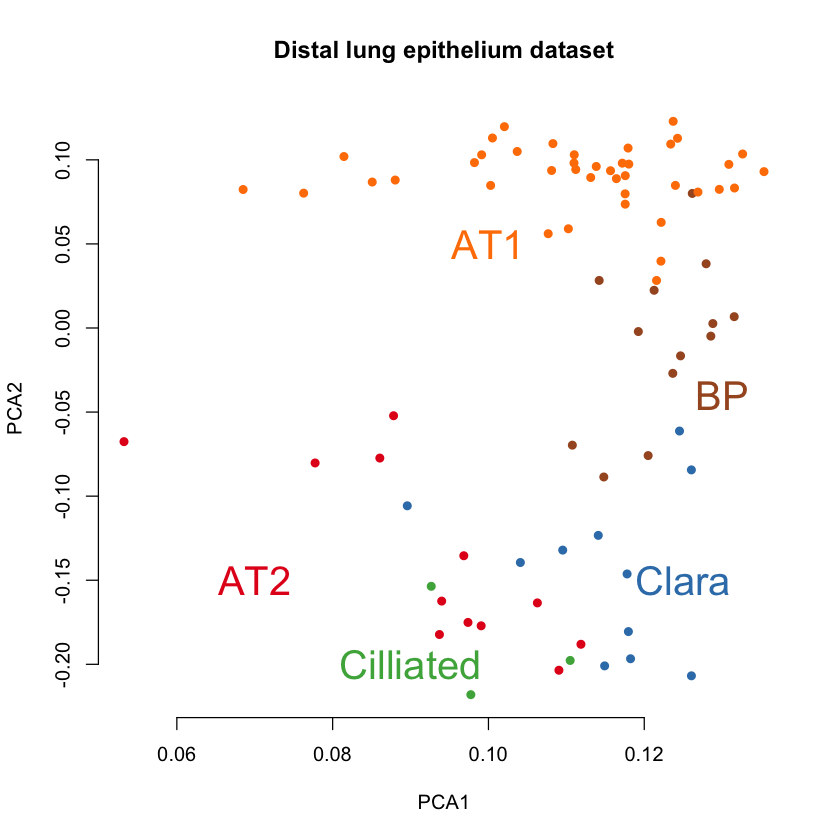

In [3]:
par(ask=FALSE)
plot(pca.DistalLungEpithelium, col=label.DistalLungEpithelium,
	pch=16, main="Distal lung epithelium dataset",
	xlab="PCA1", ylab="PCA2", bty="n")
text(0.1, 0.05, "AT1", col="#FF7F00", cex=2)
text(0.07, -0.15, "AT2", col="#E41A1C", cex=2)
text(0.13, -0.04, "BP", col="#A65628", cex=2)
text(0.125, -0.15, "Clara", col="#377EB8", cex=2)
text(0.09, -0.2, "Cilliated", col="#4DAF4A", cex=2)

scTGIFを実行するためには、他に[MSigDB](http://software.broadinstitute.org/gsea/msigdb/index.jsp)が提供している遺伝子セット（GMTファイル）が必要です

特に、Supplementary Gene Sets for Single Cell Identitiesは、細胞型を分類するのに有用なマーカー遺伝子が含まれているので、それを用いるのもいいかもしれません

ここでは、msigdbrパッケージのmsigdbr関数を使いHallmark gene sets（H）を利用します

In [4]:
m_df <- msigdbr(species = "Mus musculus", category = "H")[, c("gs_name", "entrez_gene")]

scTGIFは、GSEABaseパッケージで定義された、GeneSetCollectionオブジェクトを入力として要求します

In [5]:
hallmark = unique(m_df$gs_name)
gsc <- lapply(hallmark, function(h){
    target = which(m_df$gs_name == h)
    geneIds = unique(as.character(m_df$entrez_gene[target]))
    GeneSet(setName=h, geneIds)
})
gmt <- GeneSetCollection(gsc)

または発現量行列はSingleCellExperimentオブジェクトに、二次元座標はreducedDimsスロットに登録します

In [6]:
sce <- SingleCellExperiment(
    assays = list(counts = DistalLungEpithelium))
reducedDims(sce) <- SimpleList(PCA=pca.DistalLungEpithelium)

また、ここでは、CPMED正規化を使って、normcountsスロットに正規化済みデータを登録します

In [7]:
CPMED <- function(input){
    libsize <- colSums(input)
    median(libsize) * t(t(input) / libsize)
}

In [8]:
normcounts(sce) <- log10(CPMED(counts(sce)) + 1)

settingTGIF関数で各種設定を行います

ここではPCAの二次元座標をレポートに用い、計算にはnormcountsスロットに登録されたCPMED値を使います

In [9]:
settingTGIF(sce, gmt, reducedDimNames="PCA", assayNames="normcounts")


2D Grid Segmentation is running...
=== 0 % of genes are processed ===
=== 10 % of genes are processed ===
=== 20 % of genes are processed ===
=== 30 % of genes are processed ===
=== 40 % of genes are processed ===
=== 50 % of genes are processed ===
=== 60 % of genes are processed ===
=== 70 % of genes are processed ===
=== 80 % of genes are processed ===
=== 90 % of genes are processed ===
=== 100 % of genes are processed ===


calcTGIFでjoint NMFという2つの行列$X_{1}$（1303遺伝子×2500グリット）、$X_{2}$（1303遺伝子×50機能ターム）を

$X_{1} = (W + V_{1}) H_{1}$

$X_{2} = (W + V_{2}) H_{2}$

という風に同時に分解します

この時に、共通の因子行列$W$を用いることで、2つの行列をお互いに関連づけさせながら分解することができます

$H_{1}$と$H_{2}$の各々対応するベクトルを見比べることで、二次元プロットのどこらへんの細胞が、どのような遺伝子機能に関係しているのかが推測できます

<p><img alt="logo3" width="1000" src="https://dl.dropboxusercontent.com/s/uth8c92we9g7w9b/jnmf.png" /></p>

In [10]:
set.seed(1234)
calcTGIF(sce, rank=7)

Gene x Grid matrix (X) has 1303 rows and 1600 columns
Gene x Function matrix (Y) has 1303 rows and 50 columns


最後にreportTGIF関数でHTMLレポートを出力します

index.Rmd is created...

index.Rmd is compiled to index.html...

Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:IRanges':

    slice


The following object is masked from 'package:S4Vectors':

    rename


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn't (yet) support data arrays"
Warning message:
"textfont.color doesn

<!DOCTYPE html>

 

 

 
 
 


 


 scTGIF Report for DistalLungEpithelium dataset
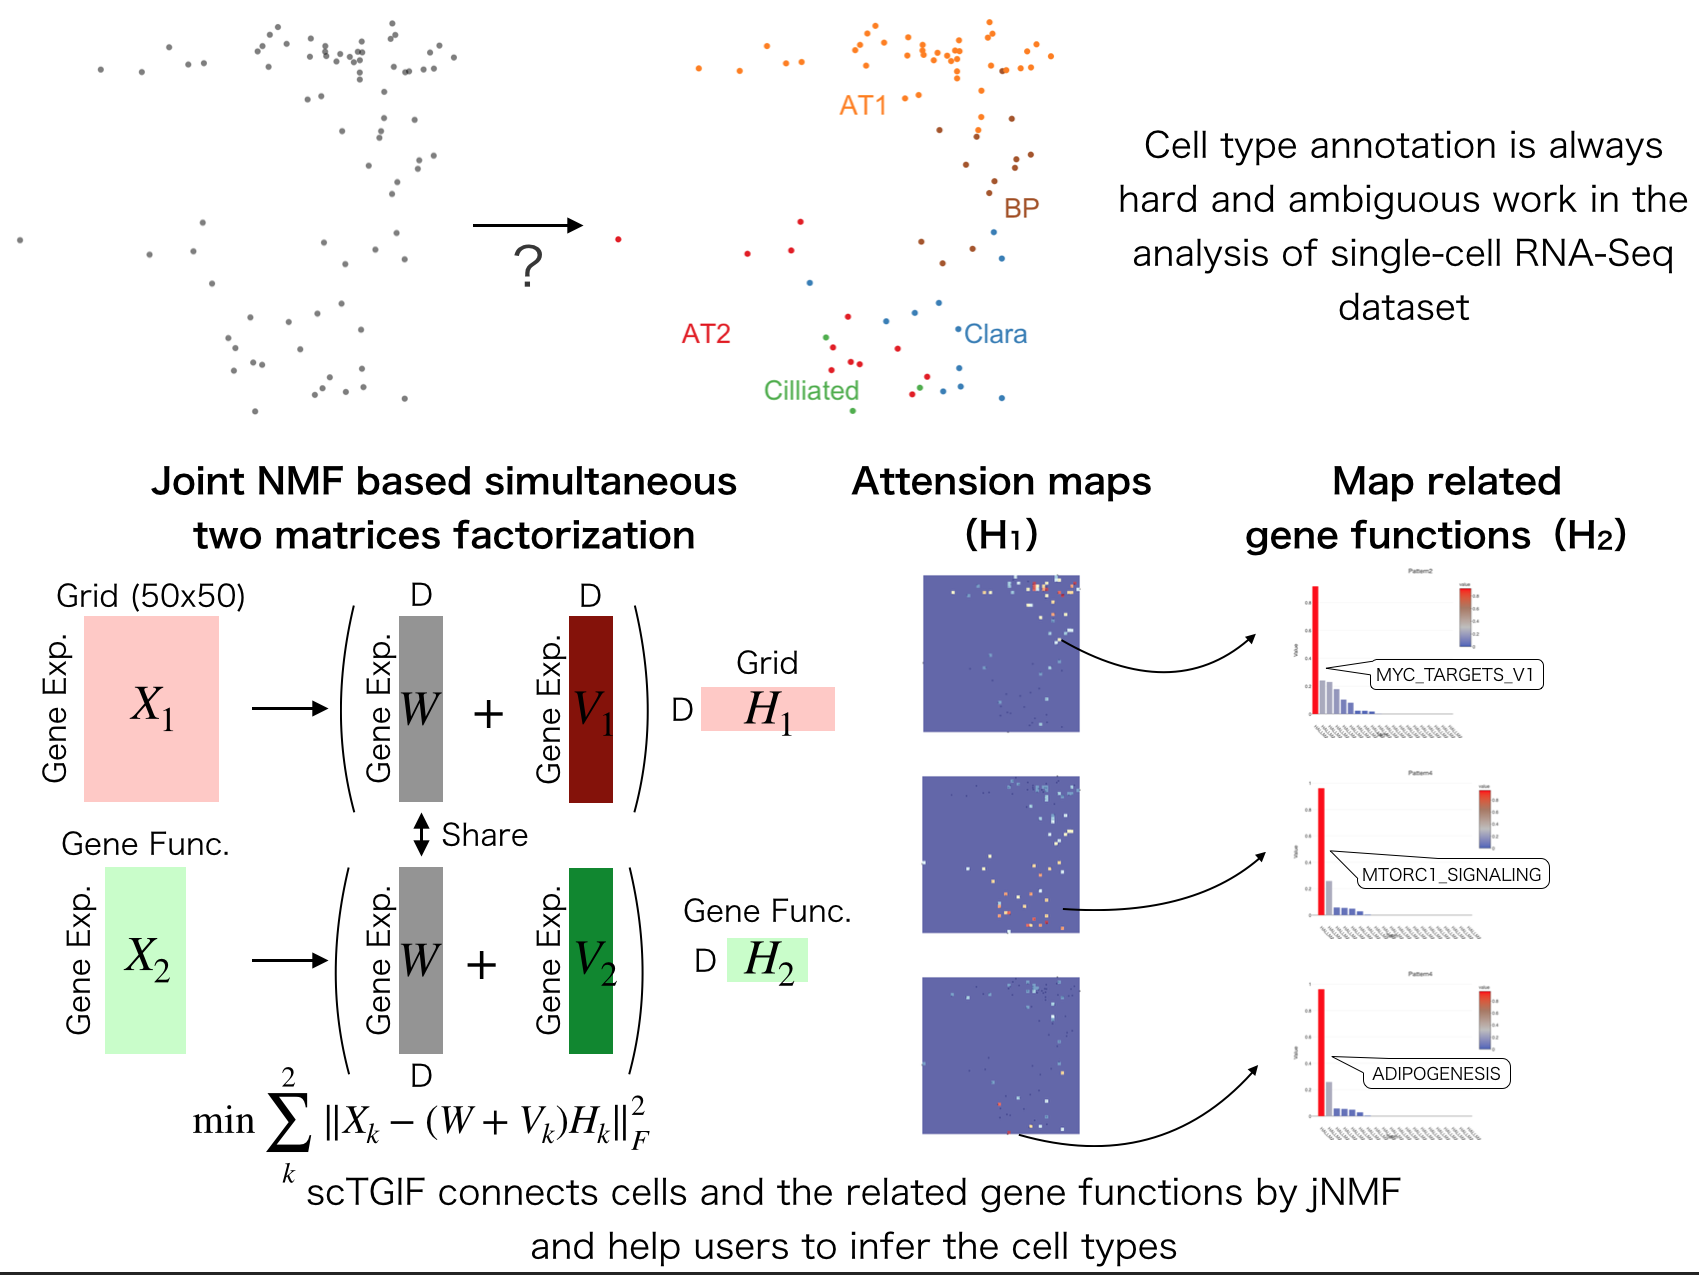
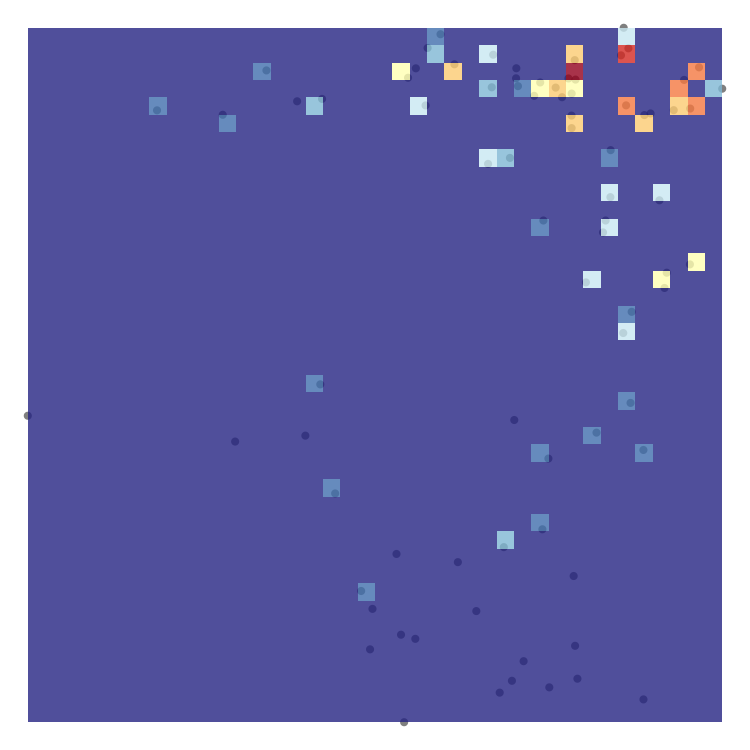
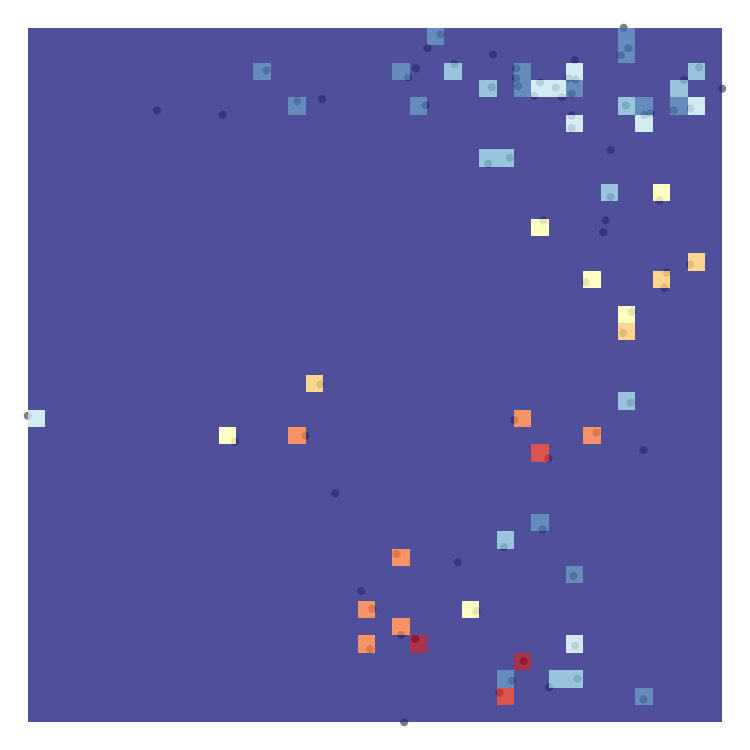
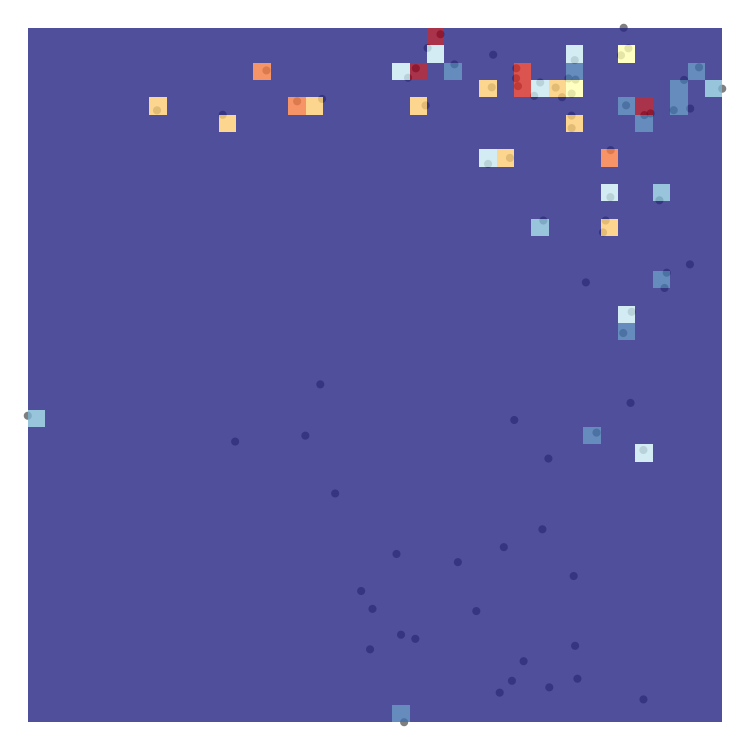
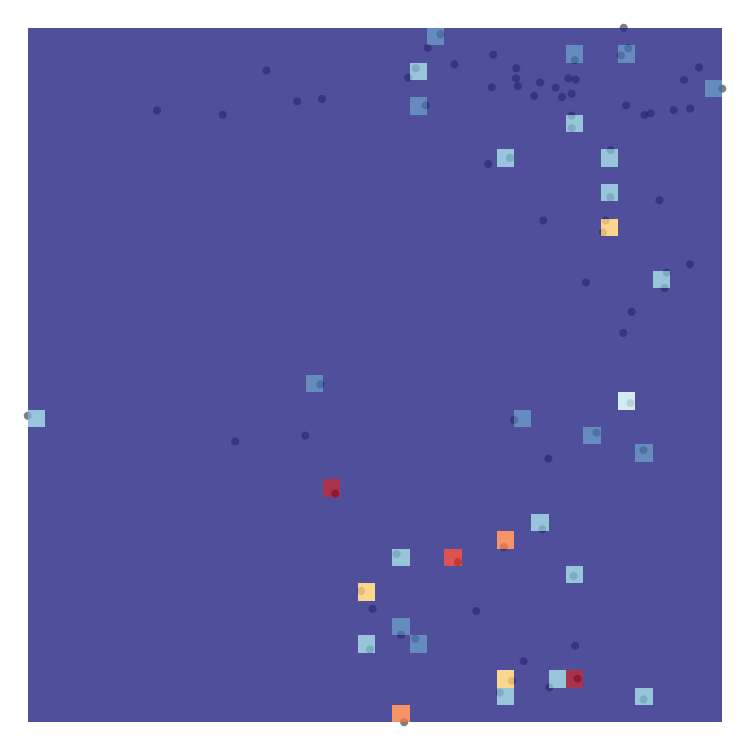
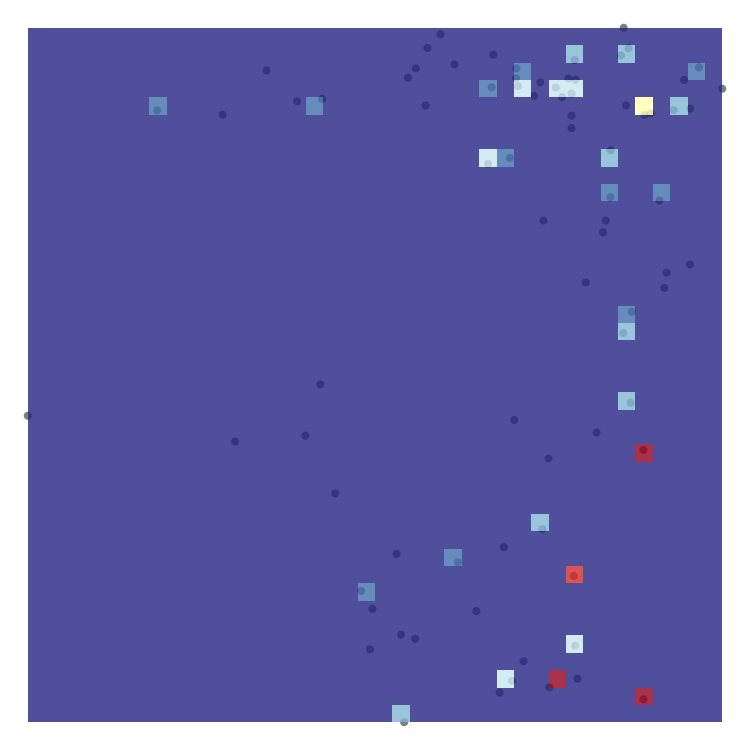

In [11]:
d <- tempdir()
reportTGIF(sce, html.open=FALSE, out.dir=d,
    title="scTGIF Report for DistalLungEpithelium dataset", author="Koki Tsuyuzaki")
display_html(file=paste0(d, "/index.html"))

In [12]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] plotly_4.9.1                ggplot2_3.2.1              
 [3] BiocStyle_2.14.2            IRdisplay_0.7.0            
 [5] scTGIF_1.0.1                msigdbr_7.0.1              
 [7] GSEABase_1.48.0             graph_1.64.0               
 [9] annotate_1.64.0             XML_3.98-1.20              
[11] AnnotationDbi_1.48.0        SingleCellExperiment_1.8.0 
[13] SummarizedExperiment_1.16.0 DelayedArray_0.12.1        
[15] BiocParallel_1.20.0         matrixStats_0.55.0         
[17] Biobase_2.46.0         

Colaboratory ノートブックの操作について詳しくは、<a href="/notebooks/basic_features_overview.ipynb">Colaboratory の概要</a>をご覧ください。